# Data engineering

this notebook does:

* create the ``dataset.csv`` (time corrected by ``flat``, ``terrace`` and ``others``)
* create the ``dataset_encoded.csv``
* create the encoding.pkl (for ``type``, ``duration``, ``ppd`` and ``age``)

In [143]:
test = pd.read_csv('data/walthamstow/dataset.csv')
test_flat = test[(test.type=='F') & (test.price<1000000)]
test_terrace = test[(test.type=='T') & (test.price<1000000)]
test_others = test[(test.type=='S') | (test.type=='D') | (test.type=='O') & (test.price<1000000)]

In [152]:
def gaussian(x, b, c):
        return np.exp(-np.power(x - b, 2.) / (2 * np.power(c/2.35482, 2.)))

In [224]:
x = np.linspace(0, 800000, 800000)

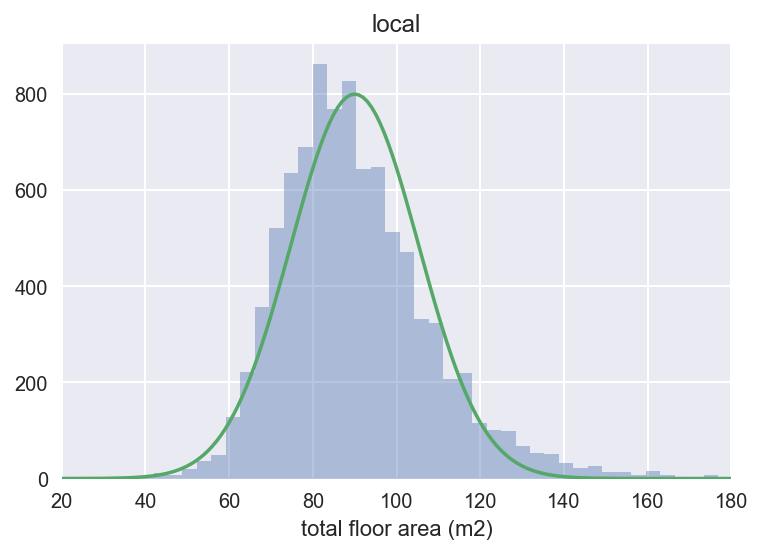

In [290]:
sns.set(style="darkgrid")
plt.title("local")
plt.xlim(20, 180)
sns.distplot(test_terrace.area.dropna(), bins=50, kde=False, axlabel='total floor area (m2)');
plt.plot(800*gaussian(x, 90, 36));

In [149]:
np.mean(test_flat.local).round(-3)

323000.0

In [150]:
np.mean(test_terrace.local).round(-3)

533000.0

In [151]:
np.mean(test_others.local).round(-3)

518000.0

In [77]:
# load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.preprocessing import LabelEncoder
import pickle
import seaborn as sns
sns.set(style="white", font_scale = 1.5)
sns.set_palette("muted")

import matplotlib.dates as mdates
from datetime import datetime
from joblib import Parallel, delayed

import json
from tqdm import tqdm
from scipy.stats import norm
from lib import PostCodeClient

import xgboost as xgb
from sklearn.model_selection import train_test_split

from __future__ import division
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### + set parameters

In [78]:
home = 'data/walthamstow/'
# lat_center = 51.59
# lon_center = -0.018
radius = 0.06
reg = 0.33 # set the regularization
precision = -3 # set the precision when price is regulated
names = ('flat', 'terrace', 'others')

### + load raw data

In [79]:
# data08 = pd.concat([pd.read_csv('data/geo/2008/data_' + str(i) + '.csv') for i in range(0, 39)],ignore_index=True)
# data09 = pd.concat([pd.read_csv('data/geo/2009/data_' + str(i) + '.csv') for i in range(0, 51)],ignore_index=True)
# data10 = pd.concat([pd.read_csv('data/geo/2010/data_' + str(i) + '.csv') for i in range(0, 58)],ignore_index=True)
# data11 = pd.concat([pd.read_csv('data/geo/2011/data_' + str(i) + '.csv') for i in range(0, 59)],ignore_index=True)
# data12 = pd.concat([pd.read_csv('data/geo/2012/data_' + str(i) + '.csv') for i in range(0, 60)],ignore_index=True)
# data13 = pd.concat([pd.read_csv('data/geo/2013/data_' + str(i) + '.csv') for i in range(0, 73)],ignore_index=True)
# data14 = pd.concat([pd.read_csv('data/geo/2014/data_' + str(i) + '.csv') for i in range(0, 88)],ignore_index=True)
# data15 = pd.concat([pd.read_csv('data/geo/2015/data_' + str(i) + '.csv') for i in range(0, 89)],ignore_index=True)
# data16 = pd.concat([pd.read_csv('data/geo/2016/data_' + str(i) + '.csv') for i in range(0, 86)],ignore_index=True)
# data17 = pd.concat([pd.read_csv('data/geo/2017/data_' + str(i) + '.csv') for i in range(0, 29)],ignore_index=True)
# big_data = pd.concat([data08, data09, data10, data11, data12, data13, data14, data15, data16, data17], ignore_index=True)

In [80]:
big_data = pd.read_csv('data/london/dataset_postdata.csv')

In [81]:
big_data = big_data.dropna(subset=['number_of_rooms'], how='all')

In [83]:
len(big_data)

401622

In [84]:
big_data.created.min(), big_data.created.max()

('2008-01-02', '2017-07-27')

### + select city

In [85]:
city = big_data.city.value_counts().index[0]
city

'LONDON'

In [86]:
data = big_data[big_data.city==city]
len(data)

401622

### + locality

In [87]:
locality = data.admin_district.value_counts().index[6]
print locality
data = big_data[big_data.admin_district==locality]

Waltham Forest


### + select a small circle region

In [90]:
data = data[data.created>='2015-01-01']

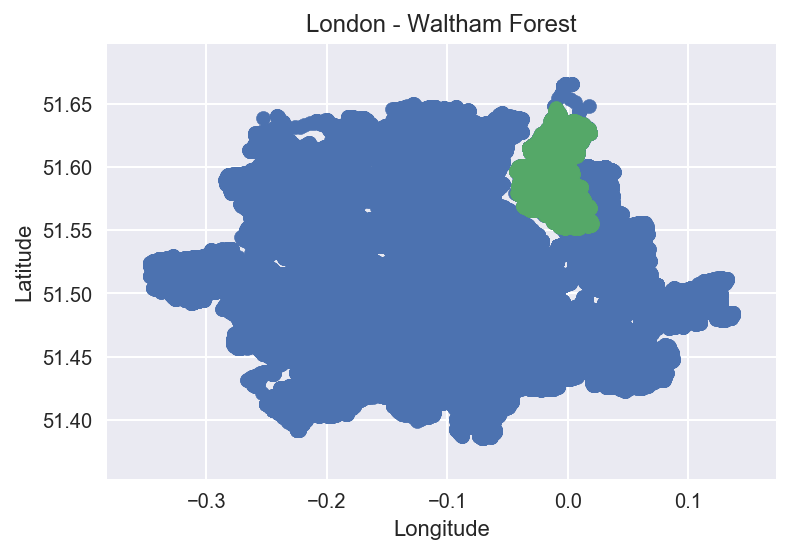

In [93]:
sns.set(style="darkgrid")
plt.title("London - " + locality)
plt.xlabel("Longitude")
plt.ylabel(u"Latitude")
plt.scatter(big_data[big_data.city==city].longitude, big_data[big_data.city==city].latitude);
plt.scatter(data.longitude, data.latitude);

In [107]:
data.property_type.unique()

array(['F', 'T', 'S', 'D', 'O'], dtype=object)

In [108]:
data.to_csv(('data/london/dataset_regularized.csv'), index=False)

### + insert postcode.io features

In [21]:
data.admin_district.unique()

array(['Waltham Forest'], dtype=object)

### + type distribution

In [26]:
data.property_type.value_counts()

T    3198
F    2702
S     631
D      84
O      77
Name: property_type, dtype: int64

In [27]:
# Porcentage
[round(i/sum(data.property_type.value_counts().values), 2) for i in data.property_type.value_counts().values]

[0.48, 0.4, 0.09, 0.01, 0.01]

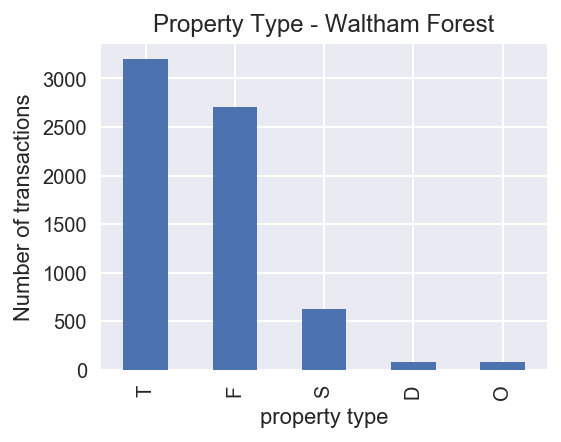

In [28]:
sns.set(style="darkgrid")
prop = pd.Series(data.property_type.value_counts())
plt.figure(figsize=(4,3))
plt.title("Property Type - " + locality)
plt.xlabel("property type")
plt.ylabel(u"Number of transactions")
prop.plot(kind='bar');

### + select the type of property

In [95]:
data_flat = data[(data.property_type=='F') & (data.price<1000000)]

data_terrace = data[(data.property_type=='T') & (data.price<1000000)]

data_others = data[(data.property_type=='S') | (data.property_type=='D') | (data.property_type=='O') & (data.price<1000000)]

print 'Flat: {}'.format(len(data_flat)) 
print 'Terrace: {}'.format(len(data_terrace))
print 'Others: {}'.format(len(data_others))

Flat: 2702
Terrace: 3191
Others: 783


In [96]:
# data_others.to_csv(('data/walthamstow/temp/raw_data_others.csv'), index=False)

In [97]:
data_flat.number_of_rooms.describe()

count    2702.000000
mean        2.896373
std         0.783244
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        10.000000
Name: number_of_rooms, dtype: float64

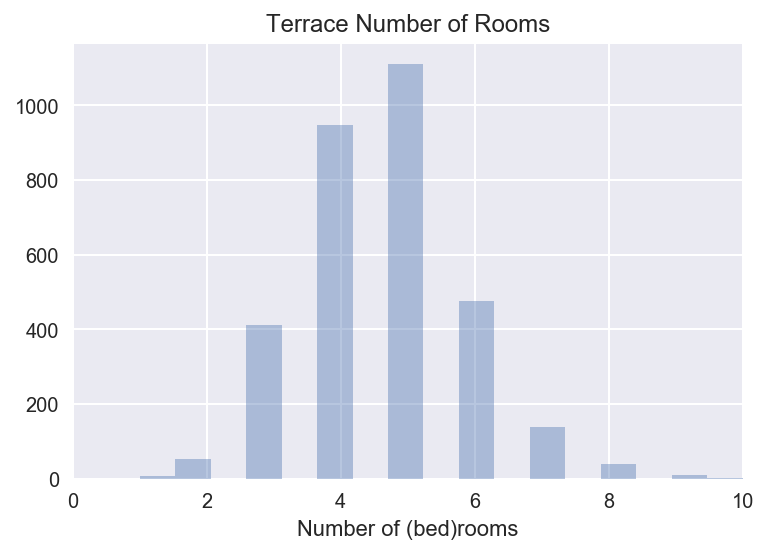

In [65]:
sns.set(style="darkgrid")
plt.title("Terrace Number of Rooms")
plt.xlim(0, 10)
sns.distplot(data_terrace.number_of_rooms.dropna(), bins=17, kde=False, axlabel='Number of (bed)rooms');

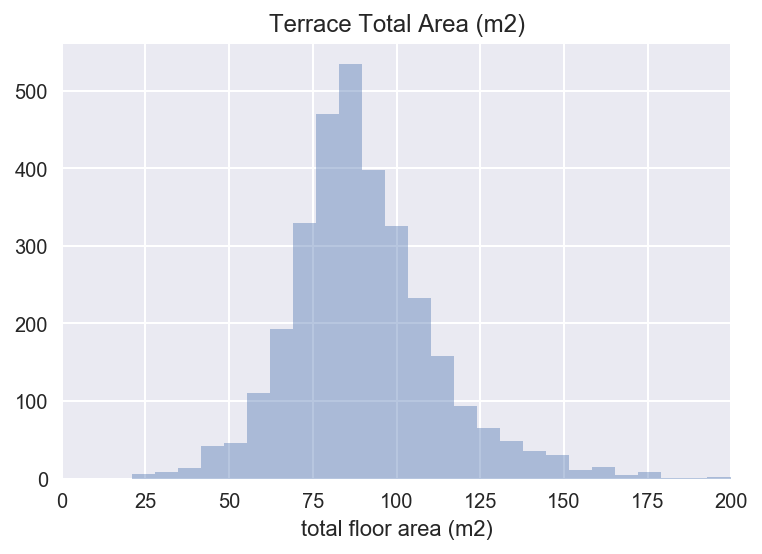

In [67]:
sns.set(style="darkgrid")
plt.title("Terrace Total Area (m2)")
plt.xlim(0, 200)
sns.distplot(data_terrace.total_floor_area.dropna(), bins=70, kde=False, axlabel='total floor area (m2)');

In [68]:
np.mean(data_flat.number_of_rooms), np.mean(data_flat.total_floor_area)

(2.8963730569948187, 56.234354552183568)

In [69]:
np.mean(data_terrace.number_of_rooms), np.mean(data_terrace.total_floor_area)

(4.6728298339078655, 90.416315888436216)

In [60]:
np.mean(data_others.number_of_rooms), np.mean(data_others.total_floor_area)

(5.0357598978288634, 102.19507151979565)

### + time correction

flat average price: 323000.0
terrace average price: 534000.0
others average price: 517000.0


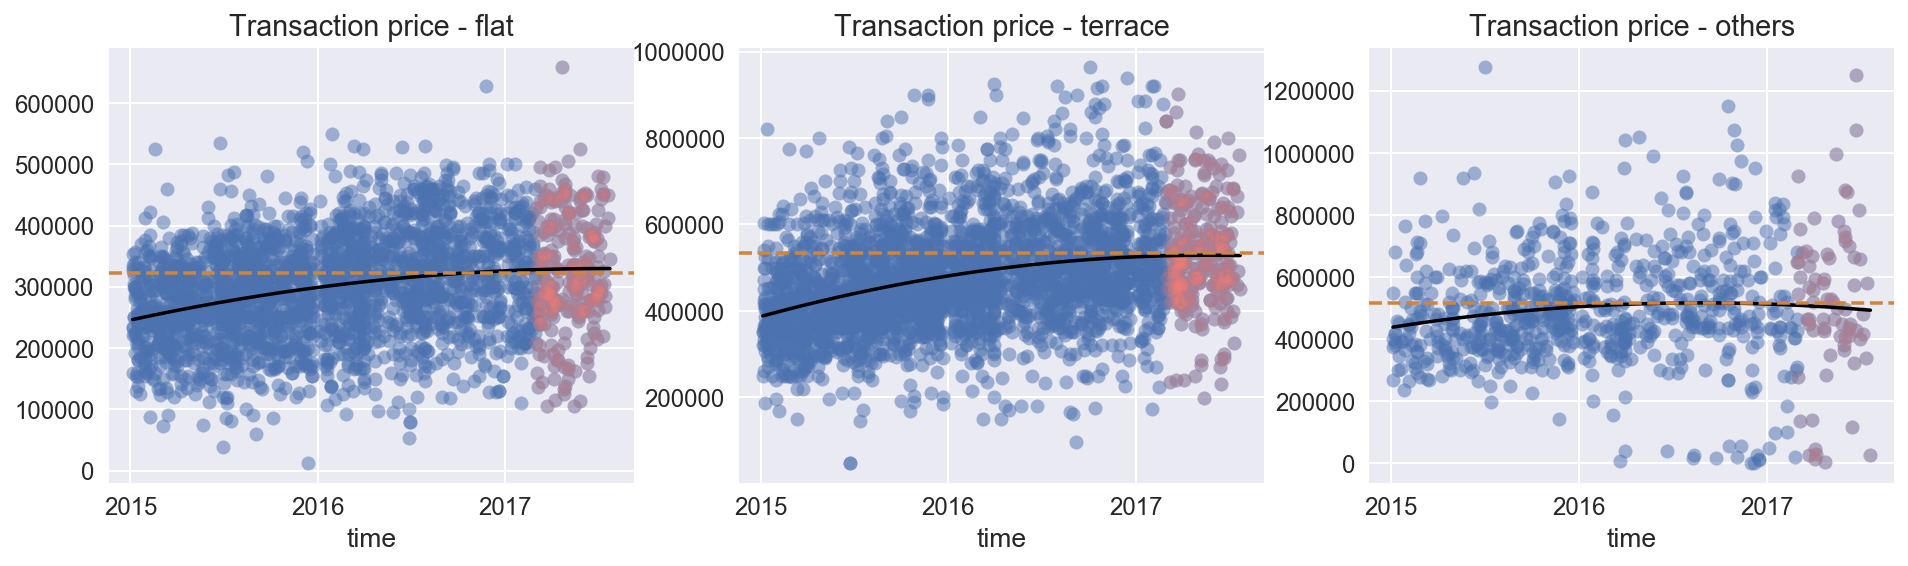

In [99]:
#Plot scatter
sns.set(style="darkgrid", font_scale = 1.2)
fig = plt.figure(figsize=(16, 4))

for i, data in enumerate([data_flat, data_terrace, data_others]):
    # calculate polynomial
    date = pd.to_datetime(data['created'])
    x = mdates.date2num(date.astype(datetime))
    z = np.polyfit(x, data['price'], 2)
    f = np.poly1d(z)
    x_new_num = np.linspace(x.min(), x.max(), 200)
    x_new = mdates.num2date(x_new_num) 
    y_new = f(x_new_num)

    ax = fig.add_subplot(1, 3, i+1)
    plt.title("Transaction price - " + names[i])
    plt.xlabel("time")
#     plt.ylabel(u"price (£)")
#     plt.ylim(-1e4, 8e5)
    years = mdates.YearLocator()   # every year
    ax.xaxis.set_major_locator(years)
    data_temp = data
    data_last = data_temp[data_temp.created>='2017-03-01']
    mean_price = np.mean(data_last.price).round(precision)
    plt.plot_date(data_temp['created'], data_temp['price'], marker='o', alpha=0.5, label='Flats');
    plt.plot_date(data_last['created'], data_last['price'], marker='o', color='salmon', alpha=0.2, label='Flats');
    plt.plot(x_new, y_new, c='black', alpha=1, label='Fit Gauss Dist');
    plt.axhline(y=mean_price, color='peru', linestyle='--');
    print '{} average price: {}'.format(names[i], mean_price)

plt.show()

In [100]:
# Time correction price

for i, data in enumerate([data_flat, data_terrace, data_others]):
    date = pd.to_datetime(data['created'])
    x = mdates.date2num(date.astype(datetime))
    z = np.polyfit(x, data['price'], 2)
    f = np.poly1d(z)

    date2 = pd.to_datetime(data['created'])
    x2 = mdates.date2num(date2.astype(datetime))
    x2_new = mdates.num2date(x2) 
    y2_new = f(x2)
    
    data_last = data[data.created>='2017-03-01']
    avg_last = np.mean(data_last.price).round(precision)
    
    data_temp = data['price'] + np.abs(avg_last - y2_new)
    
    avg = np.mean(data_temp).round(precision)
    
    data['new_price']= (data_temp + (avg_last - avg))  
    
#     time_func = pd.DataFrame(zip(data['created'], np.abs(avg_last - y2_new)), columns=('created', 'correct'))
#     time_func.to_csv('data/walthamstow/model/time_' + names[i] + '.csv', index=False)

In [170]:
len(data_flat)

2702

In [174]:
test_data = pd.read_csv('data/walthamstow/model/time_flat.csv')

flat average price: 323000.0
terrace average price: 534000.0
others average price: 517000.0


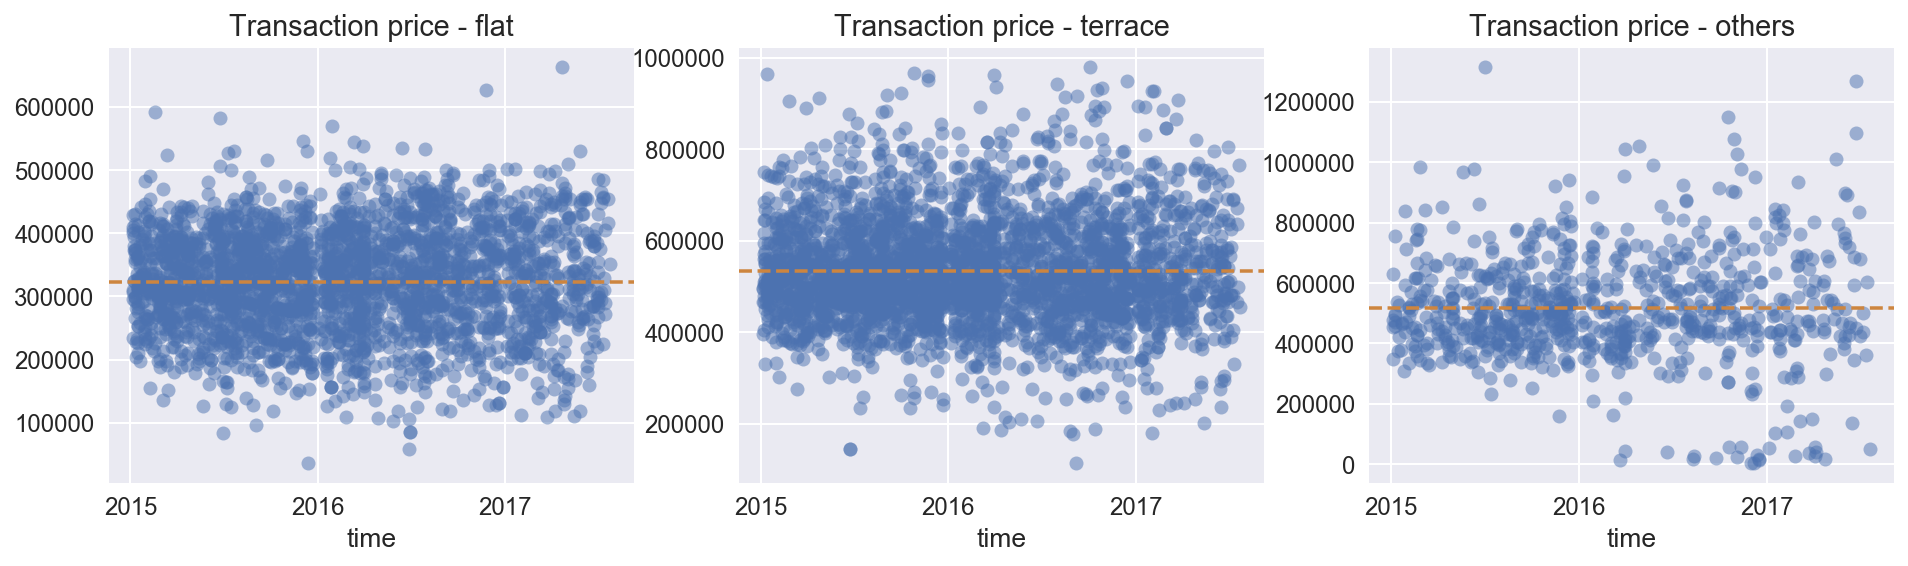

In [101]:
#Plot scatter
sns.set(style="darkgrid", font_scale = 1.2)
fig = plt.figure(figsize=(16, 4))

for i, data in enumerate([data_flat, data_terrace, data_others]):
    ax = fig.add_subplot(1, 3, i+1)
    plt.title("Transaction price - " + names[i])
    plt.xlabel("time")
    years = mdates.YearLocator()   # every year
    ax.xaxis.set_major_locator(years)
    data_temp = data
    mean = np.mean(data['new_price']).round(precision)
    plt.plot_date(data_temp['created'], data_temp['new_price'], marker='o', alpha=0.5, label='Flats');
    plt.axhline(y=mean, color='peru', linestyle='--');
    
    print '{} average price: {}'.format(names[i], mean)

plt.show()

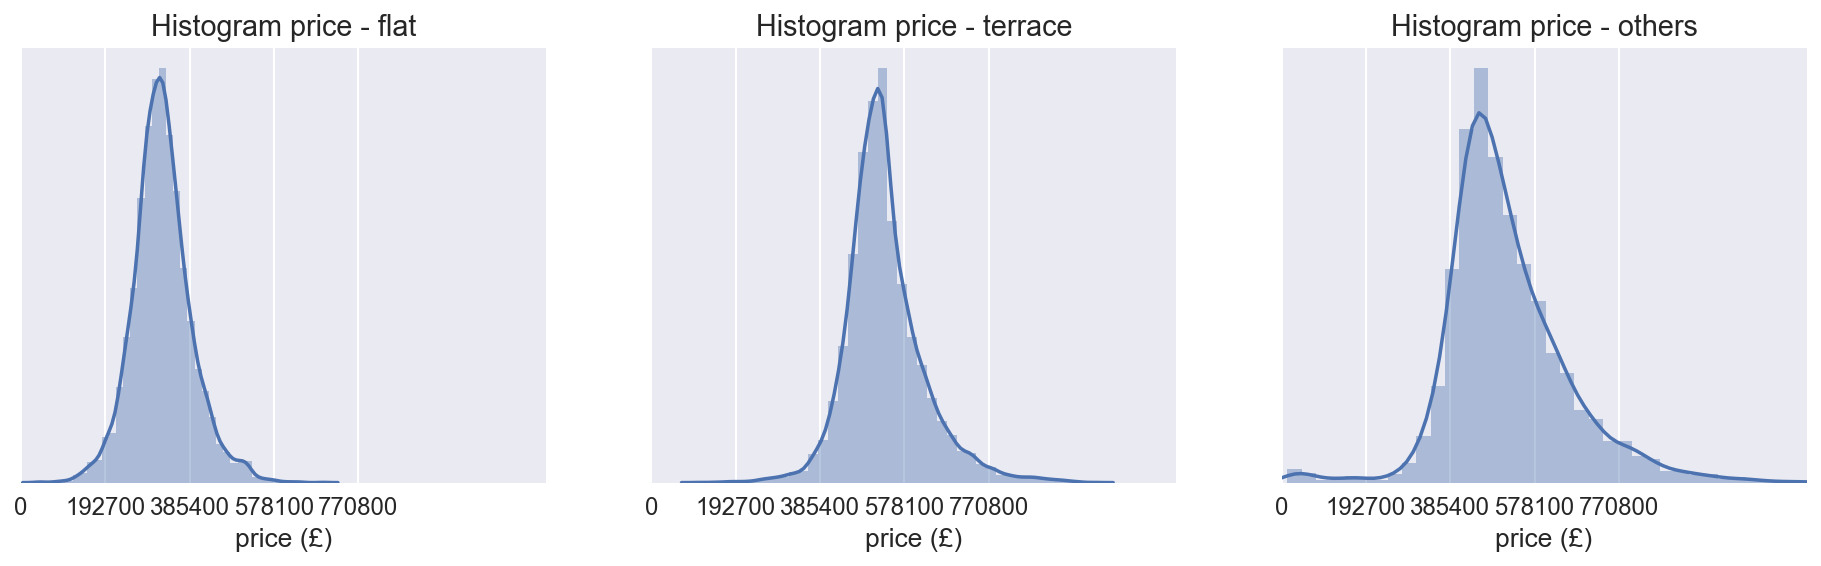

In [400]:
# Plot Histogram
sns.set(style="darkgrid", font_scale = 1.2)
fig = plt.figure(figsize=(16, 4))

for i, data in enumerate([data_flat, data_terrace, data_others]):
    ax = fig.add_subplot(1, 3, i+1)
    plt.title("Histogram price - " + names[i])
    ax.yaxis.set_visible(False)
    plt.xlim(0, 12e5)
    ax.xaxis.set_ticks(np.arange(0,max(data_terrace.price), int(max(data_terrace.price)/5)))
    sns.distplot(data['new_price'], bins=40, axlabel=u'price (£)');
plt.show()

In [401]:
for i, data in enumerate([data_flat, data_terrace, data_others]):
    data.drop(['price'],axis=1,inplace=True)

In [402]:
try:
    data_flat.price.unique()
    print 'fuck!'
except: 
    print 'ok!'

ok!


### + sqr_meter price regularization

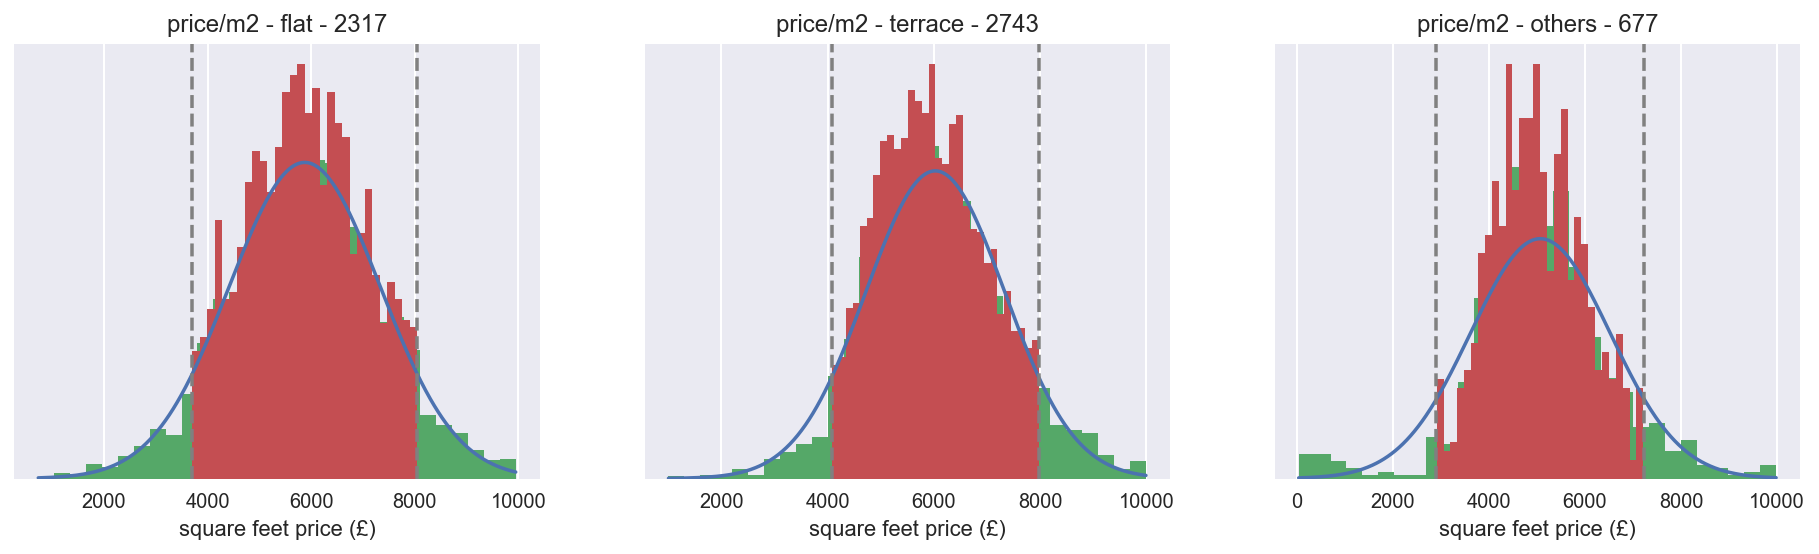

In [102]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(16, 4))
filter_data = {}
for i, data_set in enumerate([data_flat, data_terrace, data_others]):
    data_set = data_set[((data_set.new_price / data_set.total_floor_area) < 10000)] # rough regularization
    sqrm = data_set.new_price / data_set.total_floor_area

    hist, bin_edges = np.histogram(sqrm, bins=30, normed=True)
    x = np.linspace(min(sqrm), max(sqrm), 500)

    (mu, sigma) = norm.fit(sqrm)
    gaus = mlab.normpdf(x, mu, sigma)
    idx = np.abs(gaus - (max(gaus) * reg)).argsort()[:2]
    low, high = np.sort(x[idx])
    filter_data[names[i]] = names[i], low, high

    data_set = data_set[((data_set.new_price / data_set.total_floor_area) < high) & ((data_set.new_price / data_set.total_floor_area) > low)]
    sqrm_data_set = data_set.new_price / data_set.total_floor_area
    
    ax = fig.add_subplot(1, 3, i+1)
    plt.title("price/m2 - " + names[i] + ' - ' + str(len(data_set)))
    plt.xlabel(u"square feet price (£)")
    ax.yaxis.set_visible(False)
    plt.plot(x, gaus);
    plt.hist(sqrm, bins=30, normed=True)
    plt.hist(sqrm_data_set, bins=30, normed=True);
    plt.axvline(x=low, color='gray', linestyle='--');
    plt.axvline(x=high, color='gray', linestyle='--');

plt.show()

In [103]:
low, high

(2904.7801093138573, 7231.8803864646698)

In [405]:
new_data = data[data.created>'2017-01-01']

In [75]:
new_data['sqftm'] = new_data.new_price / new_data.total_floor_area

In [104]:
#filter data
data_flat = data_flat[((data_flat.new_price / data_flat.total_floor_area) < filter_data['flat'][2]) & ((data_flat.new_price / data_flat.total_floor_area) > filter_data['flat'][1])]
data_terrace = data_terrace[((data_terrace.new_price / data_terrace.total_floor_area) < filter_data['terrace'][2]) & ((data_terrace.new_price / data_terrace.total_floor_area) > filter_data['terrace'][1])]
data_others = data_others[((data_others.new_price / data_others.total_floor_area) < filter_data['others'][2]) & ((data_others.new_price / data_others.total_floor_area) > filter_data['others'][1])]

### + clustering local average price

In [46]:
# Rename new_price to price
data = data.rename(columns={'new_price': 'price'})

In [47]:
print 'Flat: {}'.format(len(data_flat)) 
print 'Terrace: {}'.format(len(data_terrace))
print 'Others: {}'.format(len(data_others))

Flat: 7607
Terrace: 9681
Others: 2337


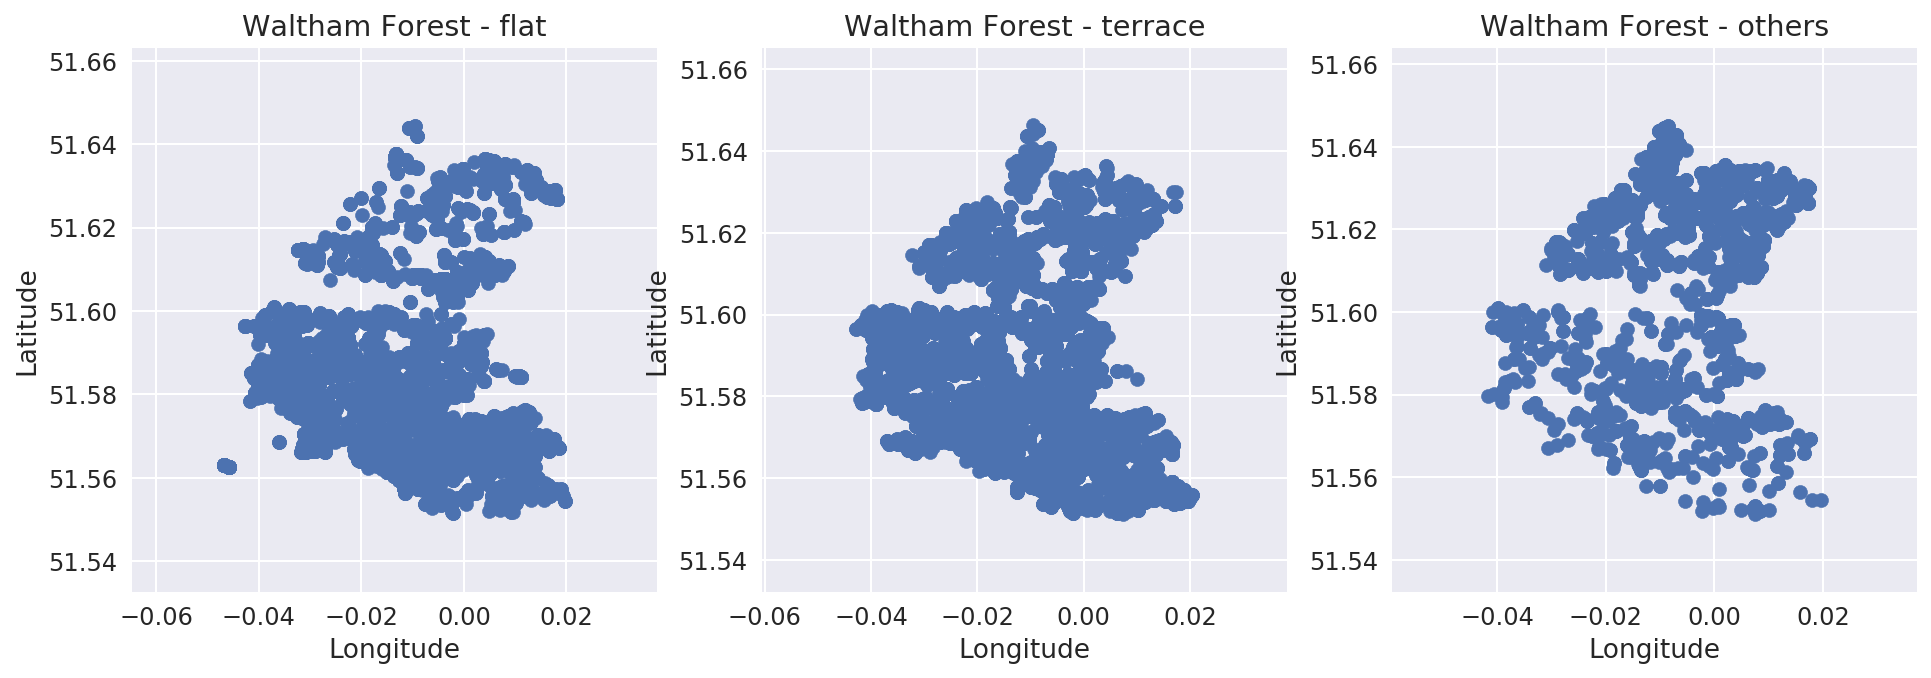

In [48]:
sns.set(style="darkgrid", font_scale = 1.2)
fig = plt.figure(figsize=(16, 5))

for i, data in enumerate([data_flat, data_terrace, data_others]):
    ax = fig.add_subplot(1, 3, i+1)
    plt.title(locality + ' - ' + names[i])
    plt.xlabel("Longitude")
    plt.ylabel(u"Latitude")
    plt.scatter(data.longitude, data.latitude);
plt.show()

In [49]:
# Define function average the prices within a neighbor range centered in each transaction in data

def local (xc, yc, data):
    soma = []
    for x, y, price in zip(data.latitude, data.longitude, data.new_price):
        if ((((x - xc)**2 + (y - yc)**2) < 0.003**2) & (((x - xc)**2 + (y - yc)**2) != 0)):
            soma = np.append(soma, price)
    return np.round(np.mean(soma), -4)

In [50]:
data_temp = data_flat.copy()
data_flat['local'] = Parallel(n_jobs=24)(delayed(local) (xc, yc, data_temp) 
                                         for xc, yc in tqdm(zip(data_flat.latitude, data_flat.longitude), ncols=80))

100%|███████████████████████████████████████| 7607/7607 [03:42<00:00, 25.56it/s]


In [51]:
print sum([i for i in data_flat.local.isnull().values])
data_flat = data_flat.dropna(subset=['local'], how='all')

20


In [52]:
data_flat.to_csv((home + 'temp/data_flat.csv'), index=False)

In [53]:
data_temp = data_terrace.copy()
data_terrace['local'] = Parallel(n_jobs=24)(delayed(local) (xc, yc, data_temp) 
                                            for xc, yc in tqdm(zip(data_terrace.latitude, data_terrace.longitude), ncols=80))

100%|███████████████████████████████████████| 9681/9681 [07:24<00:00, 21.76it/s]


In [54]:
print sum([i for i in data_terrace.local.isnull().values])
data_flat = data_terrace.dropna(subset=['local'], how='all')

0


In [55]:
data_terrace.to_csv((home + 'temp/data_terrace.csv'), index=False)

In [56]:
data_temp = data_others.copy()
data_others['local'] = Parallel(n_jobs=24)(delayed(local) (xc, yc, data_temp) 
                                           for xc, yc in tqdm(zip(data_others.latitude, data_others.longitude), ncols=80))

100%|██████████████████████████████████████| 2337/2337 [00:05<00:00, 424.24it/s]


In [57]:
print sum([i for i in data_others.local.isnull().values])
data_flat = data_others.dropna(subset=['local'], how='all')

5


In [58]:
data_others.to_csv((home + 'temp/data_others.csv'), index=False)

### + concatenate data

In [105]:
# data_flat = pd.read_csv(home + '/temp/data_flat.csv')
# data_terrace = pd.read_csv(home + '/temp/data_terrace.csv')
# data_others = pd.read_csv(home + '/temp/data_others.csv')

data = pd.concat([data_flat, data_terrace, data_others], ignore_index=True)

In [97]:
min(data.new_price), max(data.new_price)

(41000.0, 1146000.0)

### + outcode and incode colum

In [5]:
# Add outcode column
data['outcode'] = data.postcode.apply(lambda x: str(x).split(" ",1)[0])

In [7]:
print data.outcode.unique()

['E4' 'E11' 'E17' 'E10' 'E15' 'E7' 'E5' 'IG8']


### + date to number of months

In [74]:
# Convert date to number of months since 2000
data['date'] = data['created'].apply(lambda x: (int(x[:4]) - 2000)*12 + int(x[5:7]))

In [76]:
max(data.date)

211

### + clean up the data

In [62]:
data.drop(['district'],axis=1,inplace=True)

In [63]:
# rename columns
data = data.rename(columns={'new_price': 'price', 'admin_district': 'district', 'admin_ward': 'ward', 'property_type' : 'type', 'number_of_rooms' : 'rooms', 
                            'total_floor_area' : 'area', 'floor_level': 'floor', 'old_new' : 'age', 'ppd_category' : 'ppd'})

In [64]:
# set relevant columns
data = data[['date', 'price', 'postcode', 'outcode', 'latitude', 'longitude', 'district', 'ward', 'msoa', 'nuts', 'type', 'duration', 'rooms', 'local', 'floor', 'area', 'age']]

In [65]:
len(data)

19605

In [66]:
# Null values
for nules in zip(list(data), sum([i for i in data.isnull().values])):
    if nules[1]!=0:
        print(nules)

('rooms', 979)
('local', 5)


In [67]:
data = data.dropna();

In [68]:
data.to_csv((home + '/dataset.csv'), index=False)

In [69]:
data.type.value_counts()

T    9564
F    6760
S    2008
D     261
O      28
Name: type, dtype: int64

## + Dataset Encoding

In [70]:
# Floor encoding
floor_encoding = {'Basement': -1, 'Ground' : 0, 'ground floor' : 0, '1st' : 1, 'mid floor' : 1, '2nd' : 2, '3rd': 3, 
                 '4th': 4, '5th': 5, '6th': 6, '7th': 7, '8th': 8, '9th': 9, '10th': 10, '11th': 11, '12th': 12, 
                 '13th': 13, '14th': 14, '15th': 15, '16th': 16, '17th': 17, '18th': 18, '19th':19, '20th': 20, 
                 '21th': 21, '21st or above': 21, 'top floor': 25, 'NODATA!': 50, 'NO DATA!': 50
                }

data.floor.loc[data.floor=='Basement'] = -1
data.floor.loc[data.floor=='Ground'] = 0
data.floor.loc[data.floor=='ground floor'] = 0
data.floor.loc[data.floor=='1st'] = 1
data.floor.loc[data.floor=='mid floor'] = 1
data.floor.loc[data.floor=='2nd'] = 2
data.floor.loc[data.floor=='3rd'] = 3
data.floor.loc[data.floor=='4th'] = 4
data.floor.loc[data.floor=='5th'] = 5
data.floor.loc[data.floor=='6th'] = 6
data.floor.loc[data.floor=='7th'] = 7
data.floor.loc[data.floor=='8th'] = 8
data.floor.loc[data.floor=='9th'] = 9
data.floor.loc[data.floor=='10th'] = 10
data.floor.loc[data.floor=='11th'] = 11
data.floor.loc[data.floor=='12th'] = 12
data.floor.loc[data.floor=='13th'] = 13
data.floor.loc[data.floor=='14th'] = 14
data.floor.loc[data.floor=='15th'] = 15
data.floor.loc[data.floor=='16th'] = 16
data.floor.loc[data.floor=='17th'] = 17
data.floor.loc[data.floor=='18th'] = 18
data.floor.loc[data.floor=='19th'] = 19
data.floor.loc[data.floor=='20th'] = 20
data.floor.loc[data.floor=='21st'] = 21
data.floor.loc[data.floor=='21st or above'] = 21
data.floor.loc[data.floor=='top floor'] = 25
data.floor.loc[data.floor=='NODATA!'] = 50
data.floor.loc[data.floor=='NO DATA!'] = 50

In [71]:
data.floor.value_counts()

 50    11377
 1      3157
 0      3078
 2       774
 3       166
 4        26
-1        19
 5        16
 6         4
 21        1
 12        1
 8         1
 7         1
Name: floor, dtype: int64

### + encoding data

In [72]:
 var_to_encode = ['outcode', 'district', 'ward', 'msoa', 'nuts', 'type', 'duration', 'age'] #postcode, city and county will not be used for training

In [73]:
def label_encoding_dict(data, columns):
    label_encoding_dict = ()
    for column_name in columns:
        le = LabelEncoder()
        le.fit(data[column_name])
        label_encoding_dict = np.append(label_encoding_dict, le)
    return label_encoding_dict

In [74]:
le_dict = label_encoding_dict(data, var_to_encode)

In [75]:
with open(home + '/label_encoding.pkl', "wb") as f:
    pickle.dump(le_dict, f)

In [76]:
with open(home + '/label_encoding.pkl', "rb") as f:
        outcode_enc, district_enc, ward_enc, msoa_enc, nuts_enc, type_enc, duration_enc, age_enc = pickle.load(f)

In [77]:
print 'type: {}'.format(type_enc.classes_)

type: ['D' 'F' 'O' 'S' 'T']


In [79]:
# Categorize
le = LabelEncoder()
for col in var_to_encode:
    data[col] = le.fit_transform(data[col])

### + final drop columns

In [81]:
data.drop(['postcode'],axis=1,inplace=True)

In [82]:
print list(data)

['date', 'price', 'outcode', 'latitude', 'longitude', 'district', 'ward', 'msoa', 'nuts', 'type', 'duration', 'rooms', 'local', 'floor', 'area', 'age']


In [83]:
len(data)

18621

___

## Save CSV dataset_encoded

In [84]:
data.to_csv((home + '/dataset_encoded.csv'), index=False)

## Save DMatrix dataset

In [85]:
data = pd.read_csv(home + '/dataset_encoded.csv')

In [86]:
x='2015-01-01'
limit = (int(x[:4]) - 2000)*12 + int(x[5:7])

In [87]:
xgb_flat = data.loc[data.type==1]
xgb_terrace = data.loc[data.type==4]
xgb_others = data.loc[(data.type==0) | (data.type==2) | (data.type==3)]

In [88]:
len(xgb_flat), len(xgb_terrace), len(xgb_others)

(6760, 9564, 2297)

In [89]:
xgb_flat_recent = xgb_flat[xgb_flat.date >= limit]
xgb_terrace_recent = xgb_terrace[xgb_terrace.date >= limit]
xgb_others_recent = xgb_others[xgb_others.date >= limit]

In [91]:
len(xgb_flat_recent), len(xgb_terrace_recent), len(xgb_others_recent)

(2226, 2632, 664)

In [92]:
for i, data in enumerate([xgb_flat, xgb_terrace, xgb_others]):
    X = data.drop(['price'], axis=1)
    y = data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    print(names[i], str(dtrain.num_row()), str(dtest.num_row()))
    dtrain.save_binary(home + 'xgb/' + names[i] + '/train.buffer')
    dtest.save_binary(home + 'xgb/' + names[i] + '/test.buffer')

('flat', '5408', '1352')
('terrace', '7651', '1913')
('others', '1837', '460')


In [93]:
for i, data in enumerate([xgb_flat_recent, xgb_terrace_recent, xgb_others_recent]):
    X = data.drop(['price'], axis=1)
    y = data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    dtest.save_binary(home + 'xgb/' + names[i] + '/test_recent.buffer')
    print(names[i], str(dtrain.num_row()), str(dtest.num_row()))

('flat', '1780', '446')
('terrace', '2105', '527')
('others', '531', '133')
